# Mateusz Ziemła - PD5


In [83]:
import numpy as np

# i broke my cuda :/
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import keras
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import Image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing import image



# Model
Loading the VGG model pretrained on imagenet

In [2]:
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 15s 0us/step


In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

As can be seen, the model takes in a 244x244 RGB image and outputs a vector with the class predictions 

The architecture is better visualized by this image:
![](vgg16.png)


In [169]:
#  helper


def showAndDescribe(file):
    im = load_img(file, target_size=(224,224))
    display(im)
    imdata = preprocess_input(
        np.expand_dims(img_to_array(im),axis=0)
        )
    pred = model.predict(imdata)
    prednames = decode_predictions(pred)[0]
    print(*[f'{r[1]}  {100*r[2]:.2f}%' for r in prednames],sep='\n' )

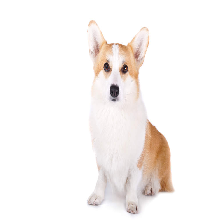

[[('n02113023', 'Pembroke', 0.25627115), ('n02109961', 'Eskimo_dog', 0.10476184), ('n02110806', 'basenji', 0.09831066), ('n02113186', 'Cardigan', 0.08163044), ('n02106030', 'collie', 0.06883001)]]


TypeError: unsupported format string passed to tuple.__format__

In [168]:
dogs = ['corg1.jpg',
        'corg2.jpeg',
        'corg3.jpg',
        'cardigan.jpg']

[showAndDescribe(dog) for dog in dogs]


I gave up on trying to confuse the model after ~40 photos, so I'm going to try to analyze what differentiates a Pembroke corgi from a Cardigan corgi according to the model

# GRAD-CAM

The GRAD-CAM algorithm below comes from [an official Keras tutorial](https://keras.io/examples/vision/grad_cam/) (comments removed for brevity)

In [67]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name = "block5_pool", pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))


In [64]:
# Remove softmax for easier explainability

model.layers[-1].activation = None
def getImdata(file):
    im = load_img(file, target_size=(224,224))
    return preprocess_input(
        np.expand_dims(img_to_array(im),axis=0)
        )

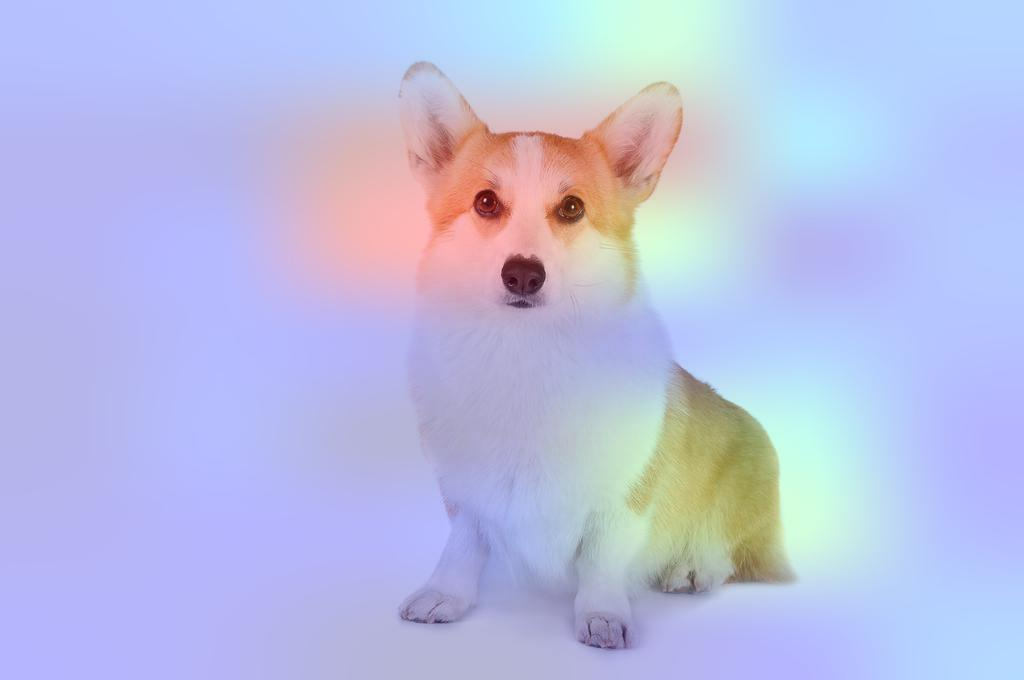

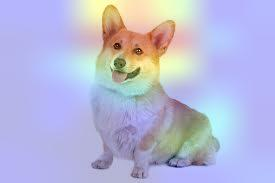

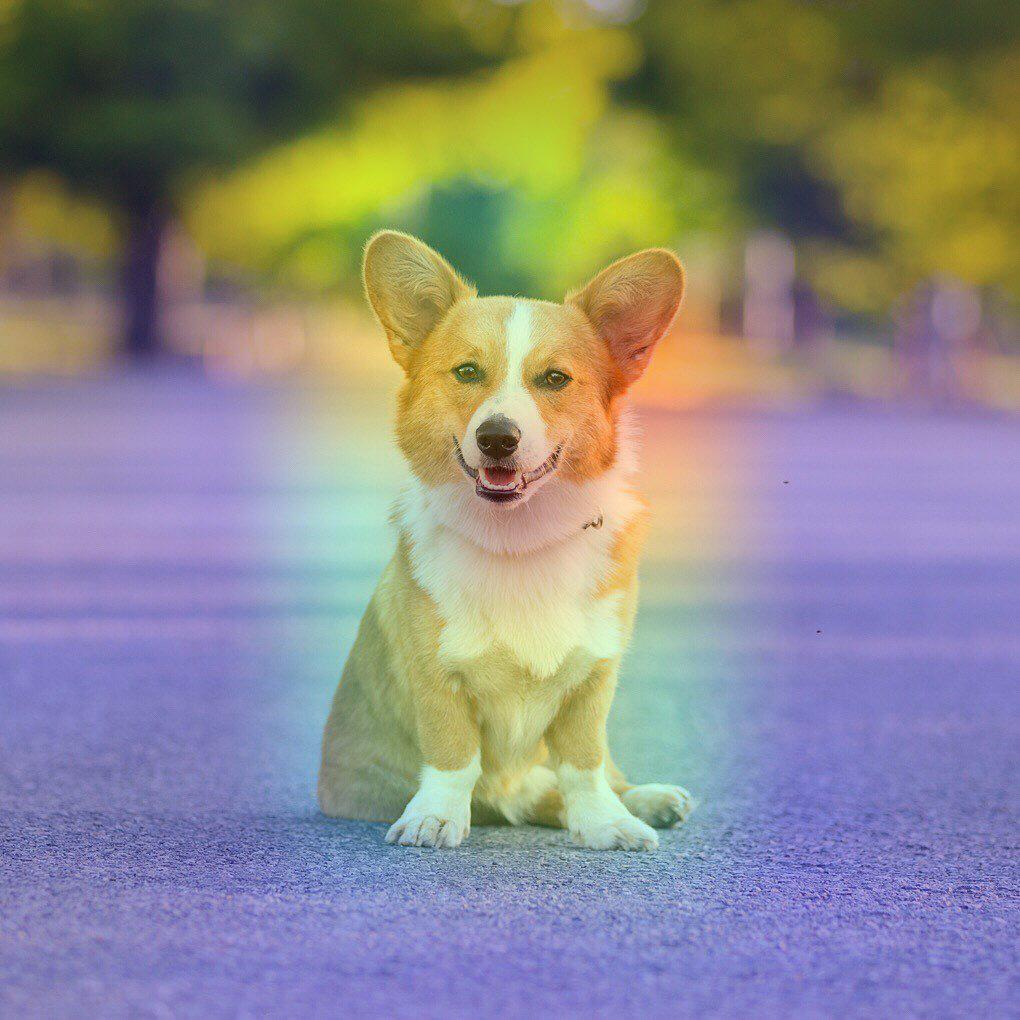

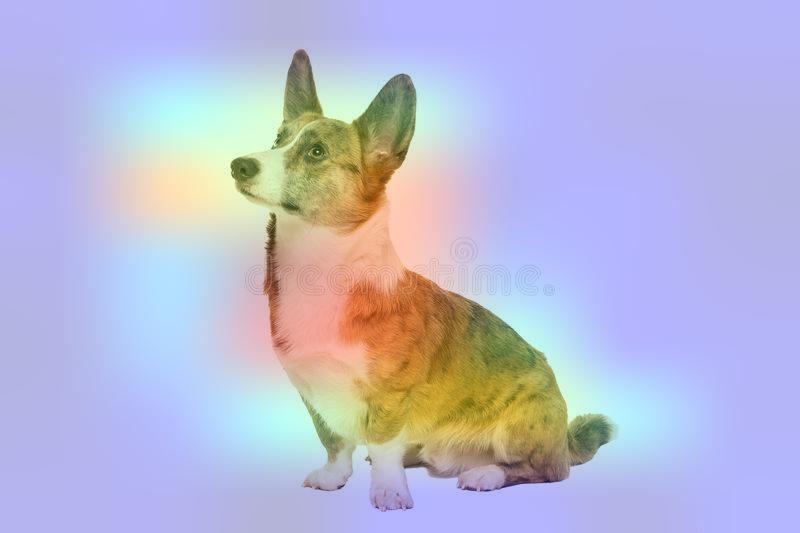

[None, None, None, None]

In [121]:



def overlappedHeatmap(file):
    imdata = getImdata(file)
    heatmap = make_gradcam_heatmap(imdata, model)
    save_and_display_gradcam(file,heatmap)

[overlappedHeatmap(dog) for dog in dogs]


It looks as if the model looks mostly at the ears, the muzzle, and the behind of a dog to generally determine it is a dog, and a corgi at one. Still, i don't really know how it differentiates between a Cardigan and a Pembroke. 

In [111]:
def showDifferences(file):
    pembrokeidx = 263
    cardiganidx = 264
    imdata = getImdata(file)
    heatmap1 = make_gradcam_heatmap(imdata, model,pred_index=pembrokeidx)
    print('Pembroke')
    save_and_display_gradcam(file,heatmap1)
    heatmap2 = make_gradcam_heatmap(imdata, model,pred_index=cardiganidx)
    print('Cardigan')
    save_and_display_gradcam(file,heatmap2)
    print('Absolute difference')
    save_and_display_gradcam(file,np.abs(heatmap1 - heatmap2))





Pembroke


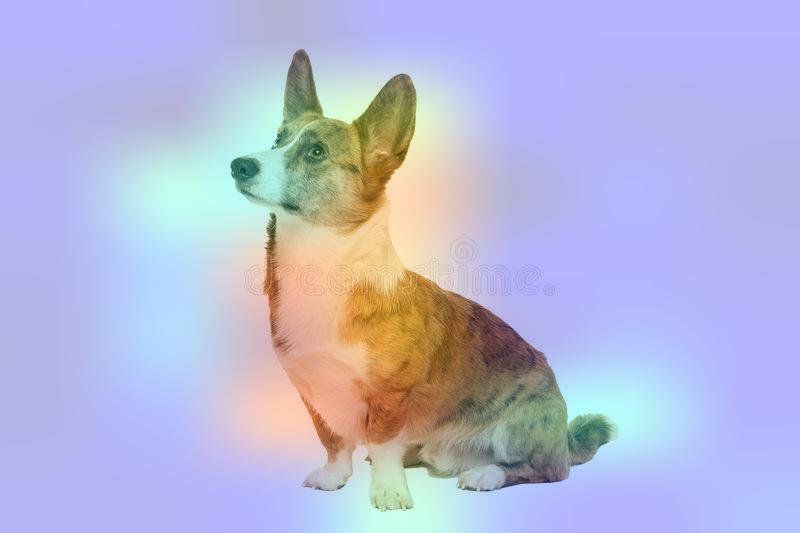

Cardigan


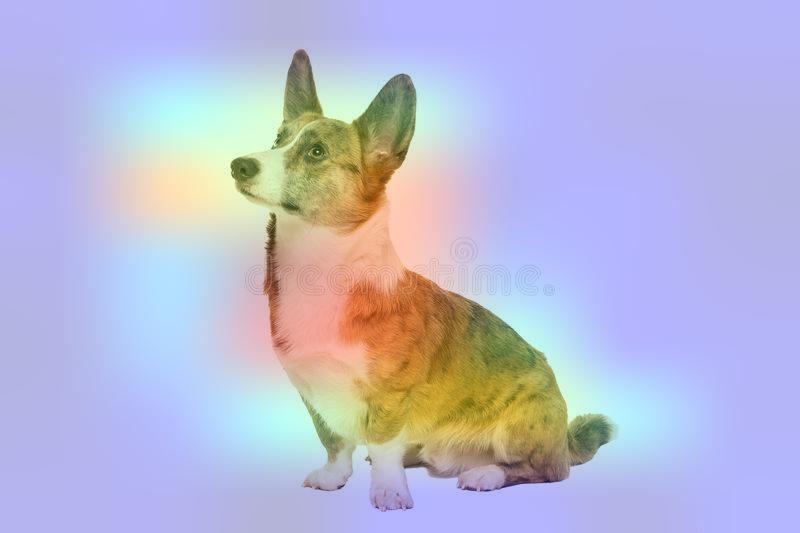

Absolute difference


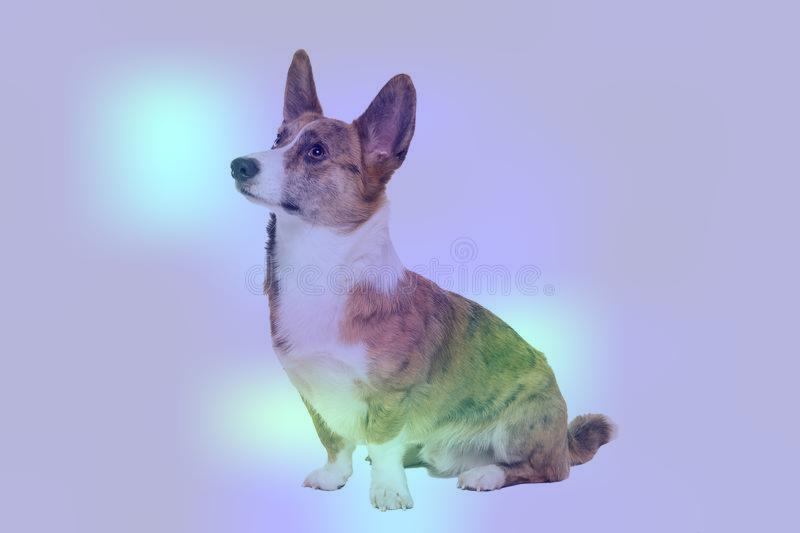

In [123]:
showDifferences(dogs[3])

Maybe it is the fur?

Pembroke


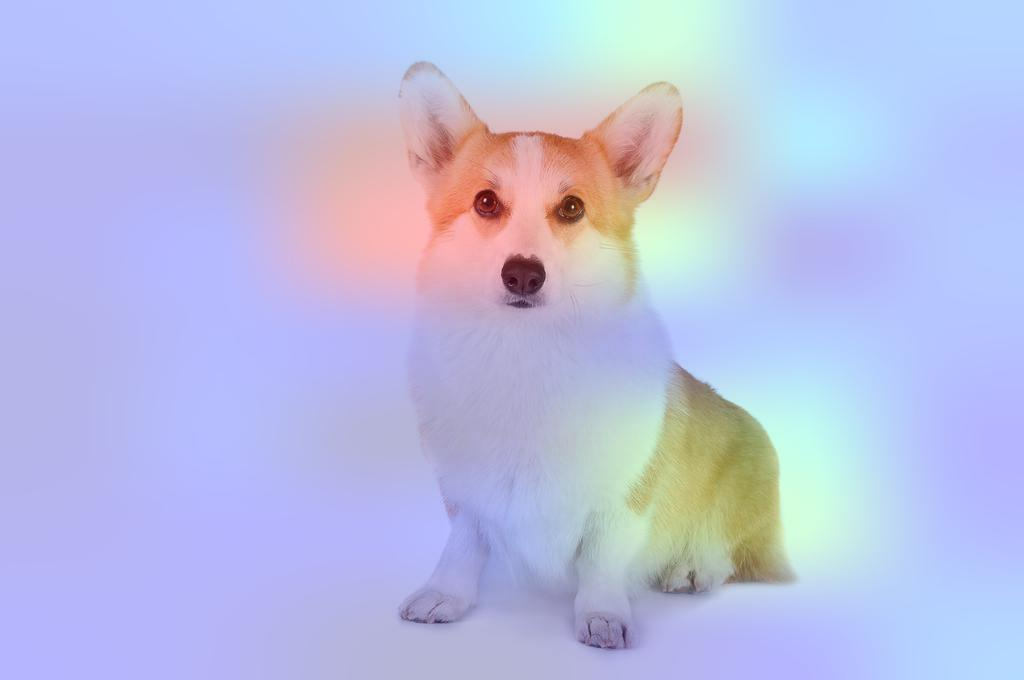

Cardigan


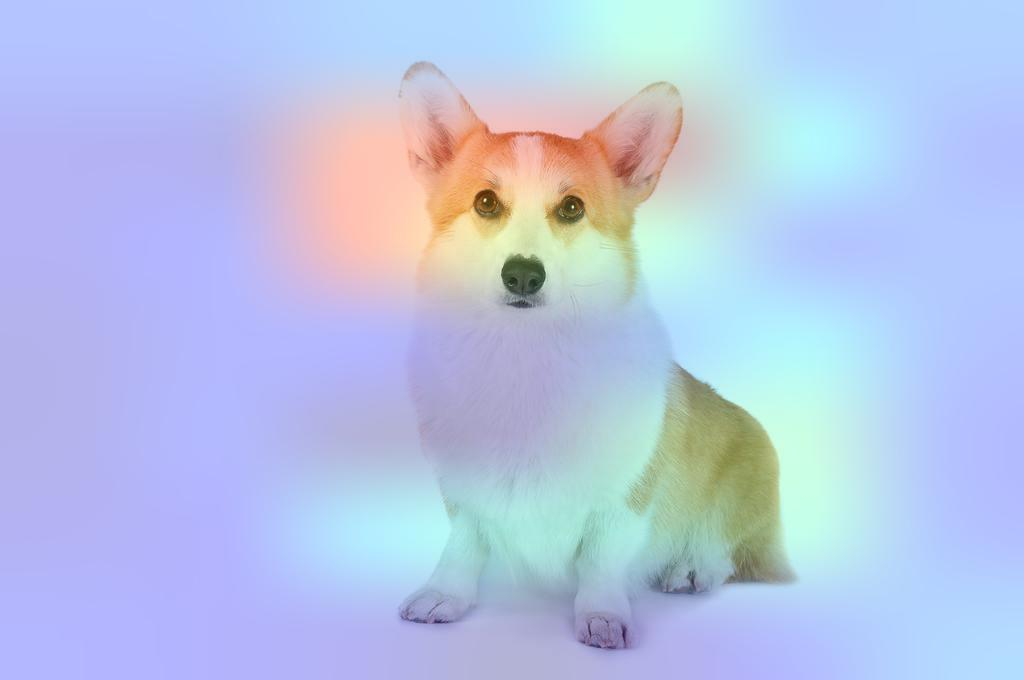

Absolute difference


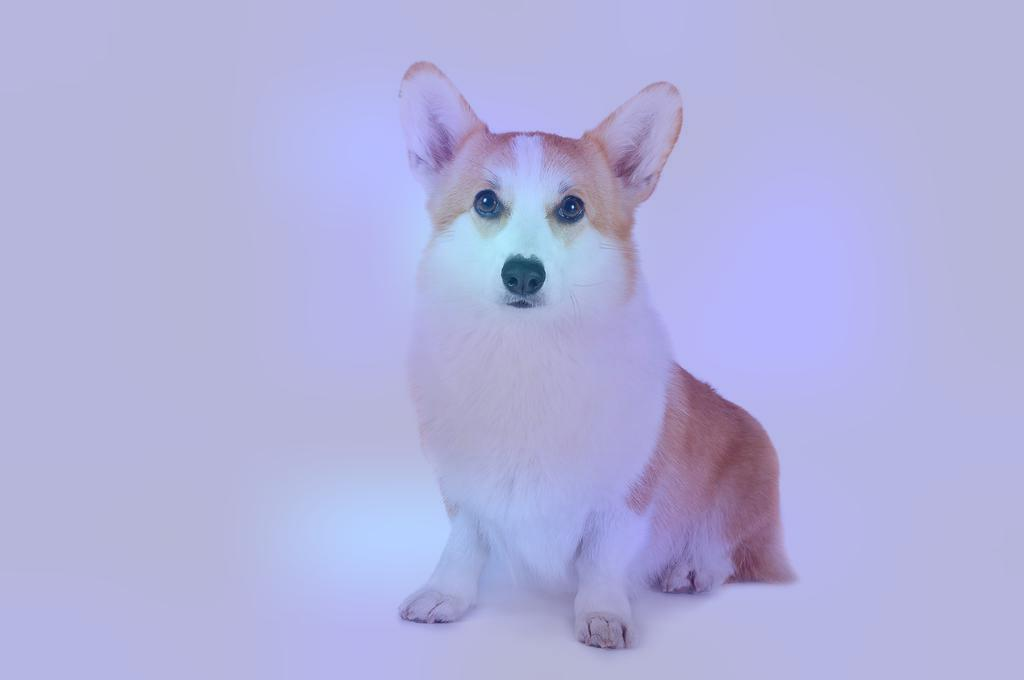

In [124]:
showDifferences(dogs[0])

The muzzles seem to play a role too

Pembroke


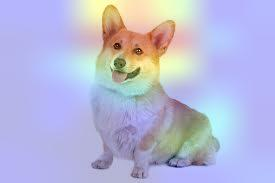

Cardigan


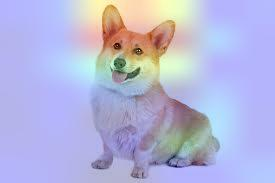

Absolute difference


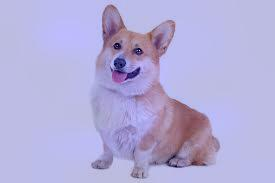

In [128]:
showDifferences(dogs[1])

And sometimes it's just the whole dog 

# LIME
Reused code taken from [here](https://www.kaggle.com/yohanb/explaining-keras-model-with-lime)

100%|██████████| 1000/1000 [02:13<00:00,  7.51it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 1000/1000 [02:21<00:00,  7.08it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 1000/1000 [02:11<00:00,  7.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] fo

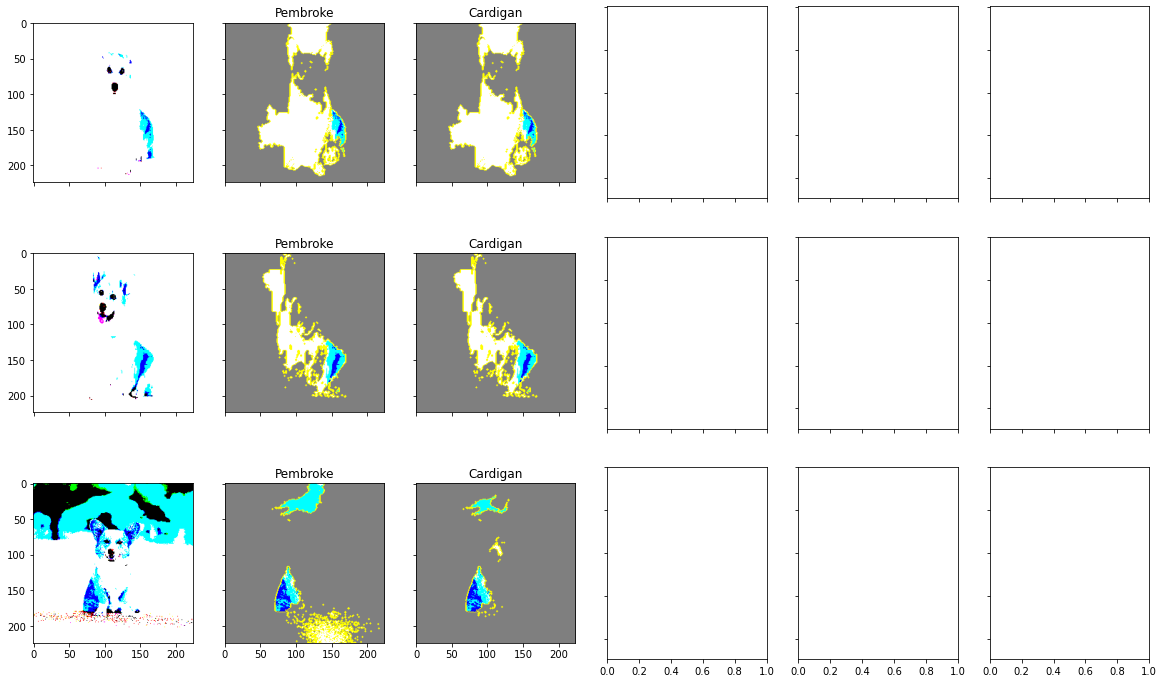

In [192]:
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image
explainer = lime_image.LimeImageExplainer()


fig, ax = plt.subplots(3, 6, sharex='col', sharey='row')
fig.set_figwidth(20)
fig.set_figheight(12)
dogData = [getImdata(f).reshape((224,224,3)).astype('double') for f in dogs]

def predfn(x):
     return model.predict(x.reshape((-1,224,224,3)))

for j in range(3):
    explanation = explainer.explain_instance(dogData[j], predfn,top_labels = 1000)
                                            
    ax[j,0].imshow(dogData[j])
    for i in range(2):
        temp, mask = explanation.get_image_and_mask(i, positive_only=True, 
                                                    num_features=5, hide_rest=True)
        ax[j,i+1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
        ax[j,i+1].set_title(f"{['Pembroke','Cardigan'][i]}")

The colour changes are caused by unscaled data, but since the LIME explainer takes a while to run, and since it doesn't matter for the sake of explanations, I'm leaving them be.

The regions which are not grey are the regions that matter for the prediction according to LIME. Sadly, there is no obvious difference between a Pembroke prediciton and a Cardigan prediction.Anyhow LIME analysis seems to confirm that the dog's behind, and it's  ears are important that it is a type of a Corgi.

Both LIME and GRAD-CAM methods seem to be vey useful for analyzing model predictions. The LIME method is great for black-box models, as it does not need to know any model specifics, but it can be really calculation intensive, as compared to GRAD-CAM. GRAD-CAM is unusable with black-box models, but it seems to work reliably and quickly on CNNs with accessible layers. Because it only uses layer weights, it is much faster, and as such can be used in analyzing more data much more quickly